In [1]:
import sys
import os
import time
import numpy as np
import numpy.fft as fourier
import math
import time

from scipy import linalg
import scipy.io as sio

from pynfft import NFFT

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline


def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(img0)
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(img1)
    sub1.set_title(title1)
    
y = sio.loadmat("export_mat/y.mat")['y'][0,0].reshape(307780)
p = np.asarray(sio.loadmat("export_mat/p.mat")["p"])
dirty = np.asarray(sio.loadmat("export_mat/dirty.mat")["dirty"])

p = (0.5)*p
p_shaped = np.reshape(p, (p.shape[0]*p.shape[1]))
dim = (64,64)

plan = NFFT(dim, y.size)
plan.x = p_shaped
plan.precompute()

plan_forward = NFFT(dim, y.size)
plan_forward.x = p_shaped
plan_forward.precompute()

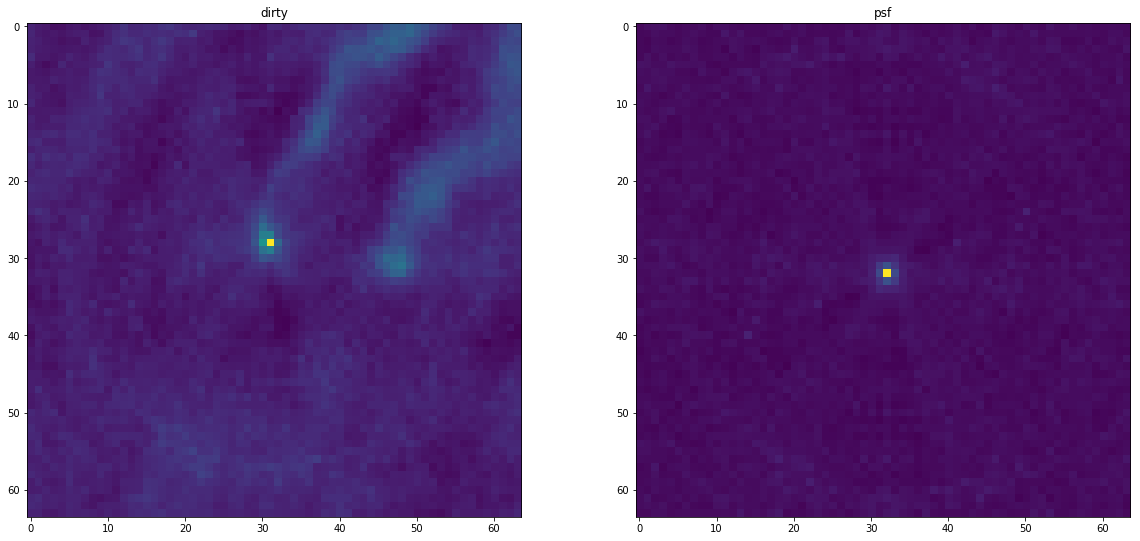

In [2]:
plan.f = np.ones(y.shape)
psf_map = np.real(plan.adjoint()).copy()
psf_map= psf_map / psf_map.sum()

plan.f = y
dirty_map = np.real(plan.adjoint()).copy()
plot_comparison(dirty_map, 'dirty', psf_map, "psf")

In [782]:
res_r = np.real(y)
res_i = np.imag(y)
lambda_cs = 0.01

p_prepped = -2j * np.pi * p
x = np.zeros(dim)
initial_res = np.sum(np.square(res_r+res_i))
print(initial_res)

5074001.036188988


In [783]:
start_res = np.sum(np.square(res_r+res_i))
print(start_res)
for pix_x in range(-18,18):
    print(pix_x+32)
    for pix_y in range(-30, 30):
        x_old = x[pix_x+32, pix_y+32]
        pix = np.asarray([pix_x, pix_y])

        f_col = np.exp(np.dot(p, pix))
        f_r = np.real(f_col)
        f_i = np.imag(f_col)
        
        #calc -b/(2a)
        a = np.sum(np.square(f_r) + 2*f_r*f_i + np.square(f_i))
        b = np.sum(f_r*res_r + f_r*res_i + f_i*res_r + f_i*res_i) # this times -2, it cancels out the -1/2 of the original equation
        x_new = b / a + x_old
        
        #shrink
        x_new = np.sign(x_new) * max(np.abs(x_new) - lambda_cs, 0.0)
        #x_new = max(0.0, x_new)
        
        x[pix_x+32, pix_y+32] = x_new
        
        diff = x_new - x_old
        if diff != 0.0:
            res_r = res_r - f_r*diff
            res_i = res_i - f_i*diff
            #if np.abs(diff) < 0.1:
            #    print("small ", diff, " x ",pix_x, " y", pix_y)
            
end_res = np.sum(np.square(res_r+res_i))
print(end_res - start_res)
print(end_res)

5074001.036188988
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
-19.884739785455167
5073981.151449203


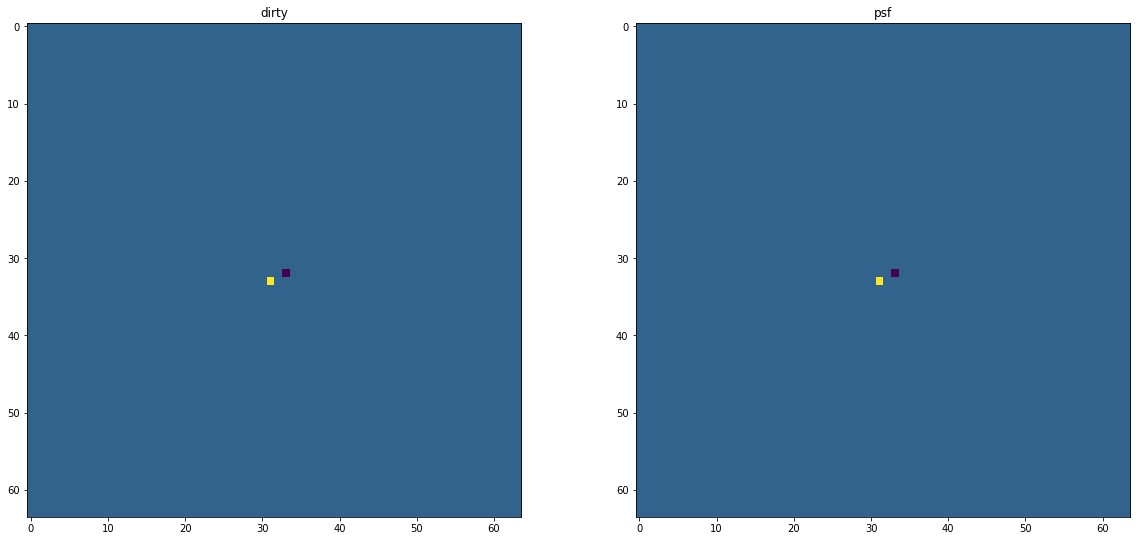

In [784]:
plot_comparison(x, 'dirty', x, "psf")

In [781]:
np.max(x)

0.0015554164548172433

# First Toy

In [337]:
F_ex = np.asarray([[0.8, 0.2],
                   [0.1, -0.1],
                   [0.1, -0.3],
                   [0.3, 0.2],
                   [0.4, -0.9]])
x_ex = np.asarray([0.7, -0.3])

v_ex = np.dot(F_ex, x_ex)
print(v_ex)

[0.5  0.1  0.16 0.15 0.55]


In [253]:
residual = v_ex
x_calc = np.zeros(2)
lambda_cs = 0.0

In [479]:

for xi in range(0, 2):
    x_old = x_calc[xi]
    f_col = F_ex[:, xi]
    
    x_new = np.sum(2* residual * f_col) / np.sum(np.square(f_col)) + x_old
    
    s = np.sign(x_new)
    x_new = s * np.max((np.abs(x_new)-lambda_cs), 0)
    x_calc[xi] = x_new
    
    if x_new != 0.0:
        print(np.sum(np.abs(residual)))
        residual = residual - f_col*(x_new - x_old)

ValueError: operands could not be broadcast together with shapes (307780,) (5,) 

In [338]:
np.dot(v_ex, F_ex)

array([ 0.691, -0.423])

In [154]:
np.sum(np.abs(residual))

0.02012304063401779

# SECOND TOY

In [718]:
x_ex = np.asarray([[30.9, 15.8, 1.7, 0.4, 0.3, 20, 0.1],
                  [0.6, 0.5, 0.4, 0.3, 0.2, 0.1 ,0.0],
                  [2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4]
                  ])

p_ex = np.zeros((x_ex.shape[0]*x_ex.shape[1], 2))
for k in range(0, x_ex.shape[0]):
    offset = k * x_ex.shape[1]
    for l in range(0, x_ex.shape[1]):
        p_ex[offset+l, 0] = k/x_ex.shape[0]
        p_ex[offset+l, 1] = l/x_ex.shape[1]
        
v_ex = np.zeros(p_ex.shape[0], dtype=np.complex128)

for xi in range(0,x_ex.shape[0]):
    for yi in range(0, x_ex.shape[1]):
        pix = np.asarray([xi , yi])
        f_forward_col = np.exp(2j * np.pi * np.dot(p_ex, pix))
        v_ex = v_ex + (f_forward_col*x_ex[xi, yi])
        
x_two = np.zeros(x_ex.shape)
for xi in range(0, x_ex.shape[0]):
    for yi in range(0, x_ex.shape[1]):
        pix = np.asarray([xi, yi])
        f_d_col = np.exp(-2j * np.pi * np.dot(p_ex, pix))
        x_two[xi, yi] = np.real(np.sum(v_ex * f_d_col)) / v_ex.size

print(np.sum(np.square(x_ex - x_two)))

1.1364774790841946e-27


In [724]:
x_calc = np.zeros(x_ex.shape)
residual = v_ex
lambda_cs = 0.0

In [725]:
for xi in range(0, x_ex.shape[0]):
    for yi in range(0, x_ex.shape[1]):
        x_old = x_calc[xi, yi]
        pix = np.asarray([xi, yi])
        
        f_col = np.exp(2j * np.pi * np.dot(p_ex, pix))
        
        f_r = np.real(f_col)
        f_i = np.imag(f_col)
        res_r = np.real(residual)
        res_i = np.imag(residual)
        
        #calc -b/(2a)
        a = np.sum(np.square(f_r) + 2*f_r*f_i + np.square(f_i))
        b = np.sum(f_r*res_r + f_r*res_i + f_i*res_r + f_i*res_i) # this times -2, it cancels out the -1/2 of the original equation
        x_new = b / a + x_old
        print("x_new",x_new)
        #shrink
        x_new = np.sign(x_new) * max(np.abs(x_new) - lambda_cs, 0.0)
        #x_new = max(0.0, x_new)
        
        x_calc[xi, yi] = x_new
        residual = residual - f_col*(x_new - x_old)


x_new 30.899999999999988
x_new 0.10000000000000853
x_new 19.999999999999996
x_new 0.2999999999999944
x_new 0.40000000000001584
x_new 1.699999999999952
x_new 15.800000000000027
x_new 1.9999999999999996
x_new 1.3999999999999984
x_new 1.5000000000000002
x_new 1.5999999999999976
x_new 1.6999999999999993
x_new 1.8000000000000007
x_new 1.9
x_new 0.6000000000000003
x_new -2.7676273971012825e-15
x_new 0.09999999999999594
x_new 0.19999999999999946
x_new 0.2999999999999975
x_new 0.3999999999999976
x_new 0.49999999999999906


In [726]:
x_calc

array([[ 3.0900000e+01,  1.0000000e-01,  2.0000000e+01,  3.0000000e-01,
         4.0000000e-01,  1.7000000e+00,  1.5800000e+01],
       [ 2.0000000e+00,  1.4000000e+00,  1.5000000e+00,  1.6000000e+00,
         1.7000000e+00,  1.8000000e+00,  1.9000000e+00],
       [ 6.0000000e-01, -2.7676274e-15,  1.0000000e-01,  2.0000000e-01,
         3.0000000e-01,  4.0000000e-01,  5.0000000e-01]])

# STUPID NUFFT CD

In [4]:
def calcSpline():
    b3spline = np.asarray([1.0 / 16.0, 1.0 / 4.0, 3.0 / 8.0, 1.0 / 4.0, 1.0 / 16.0])

    row = np.asmatrix([b3spline])
    bla = (np.dot(np.transpose(row), row))
    return (np.dot(np.transpose(row), row))

def calcConvMatrix(size, kernel, J):
    output = np.zeros((size[0] * size[1], size[0] * size[1]))
    kernel = np.fliplr(np.flipud(kernel))

    disp = 2 ** J
    mid = kernel.shape[0] // 2
    for x in range(0, size[0]):
        offset = x * size[0]
        for y in range(0, size[1]):
            temp = np.reshape(output[offset + y], size)
            for i in range(0, kernel.shape[0]):
                for j in range(0, kernel.shape[1]):
                    xi = ((i - mid) * disp + x)
                    yi = ((j - mid) * disp + y)
                    # print(xi, yi)
                    mx = xi // size[0] % 2
                    xi = xi % size[0]
                    if mx == 1:
                        xi = size[0] - 1 - xi

                    my = yi // size[1] % 2
                    yi = yi % size[1]
                    if my == 1:
                        yi = size[1] - 1 - yi
                    # print(mx, my, xi, yi)
                    temp[xi, yi] += kernel[i, j]
    return (output)

In [26]:
bspline = calcSpline()
conv = np.zeros((64,64))
conv[0:5, 0:5] = bspline
conv = np.roll(conv, (-2, -2), (0,1))

conv2 = np.zeros((64,64))
conv2[30:35, 30:35] = bspline

spline2 = np.zeros((10,10))
for xi in range(0, 5):
    for yi in range(0, 5):
        spline2[xi*2, yi*2] = bspline[xi,yi]

conv_J1 = np.zeros((64, 64))
conv_J1[28:38, 28:38] = spline2

        
conv_mat0 = calcConvMatrix((64, 64), bspline, 0)
conv_mat1 = calcConvMatrix((64, 64), bspline, 1)

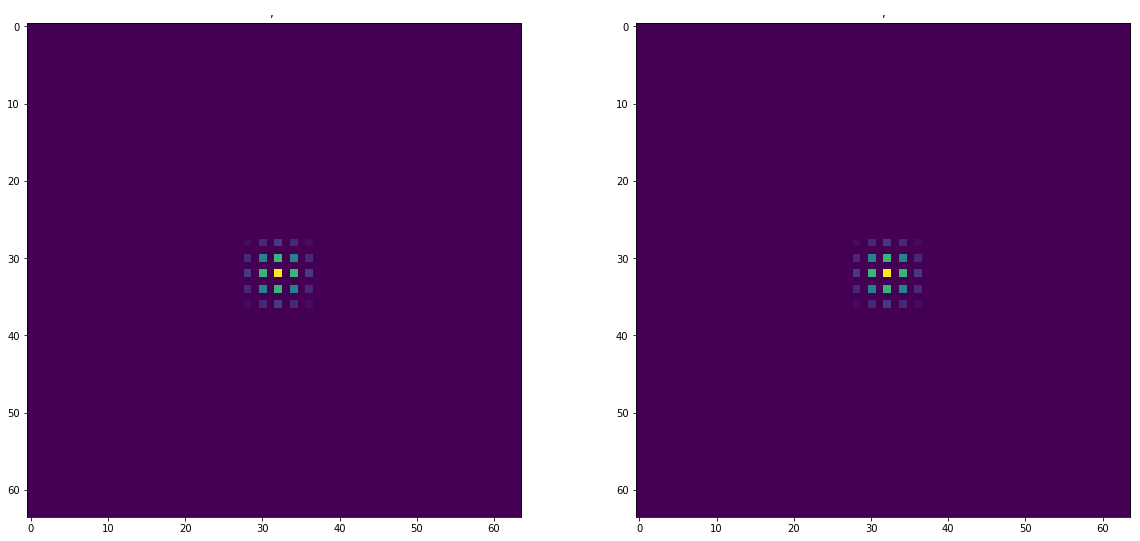

In [27]:
plot_comparison(conv_J1, ", ", conv_J1, ",")

In [32]:
plan_forward.f_hat = conv2
conv_vis0 = plan_forward.trafo().copy()

plan_forward.f_hat = conv_J1
conv_vis1 = conv_vis0 * plan_forward.trafo().copy()



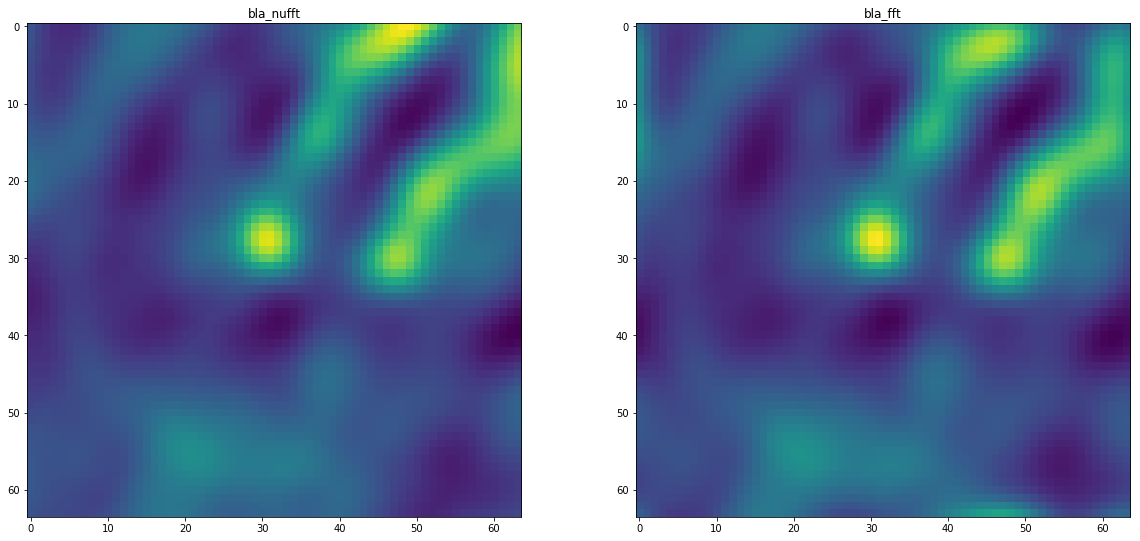

In [34]:
plan.f = y *  conv_vis1
convolved = np.real(plan.adjoint().copy())

c0 = np.reshape(np.dot(conv_mat0, dirty_map.flatten()), (64,64))
w0 = dirty_map - c0
c1 = np.reshape(np.dot(conv_mat1, c0.flatten()), (64,64))
w1 = c0 - c1
plot_comparison(convolved,"bla_nufft", c1, "bla_fft")

# THIRD EXAMPLE

In [58]:
def soft_thresh(x, l):
    x2 = np.sign(x) * np.maximum(np.abs(x) - l, 0.)
    x2 = np.maximum(x2, 0.)
    return x2

def calcSpline():
    b3spline = np.asarray([1.0 / 16.0, 1.0 / 4.0, 3.0 / 8.0, 1.0 / 4.0, 1.0 / 16.0])

    row = np.asmatrix([b3spline])
    bla = (np.dot(np.transpose(row), row))
    return (np.dot(np.transpose(row), row))

#circular
def calcConvMatrix(size, kernel, J):
    output = np.zeros((size[0]*size[1], size[0]*size[1]))
    kernel = np.fliplr(np.flipud(kernel))
    
    disp = 2**J
    temp = np.zeros(size)
    for i in range(0, kernel.shape[0]):
        for j in range(0, kernel.shape[1]):
            x = (i * disp) % temp.shape[0]
            y = (j * disp) % temp.shape[1]
            temp[x,y] += kernel[i,j]
            
    mid = (kernel.shape[0]-1) * disp + 1
    temp = np.roll(temp, -(mid//2), axis= 0)
    temp = np.roll(temp, -(mid//2), axis=1)
    
    for x in range(0, size[0]):
        offset = x * size[0]
        for y in range(0, size[1]):
            output[offset+y] = temp.flatten()
            temp = np.roll(temp, 1, axis=1)
        temp = np.roll(temp, 1, axis=0)
    return(output)

In [59]:
bspline = calcSpline()
conv_pix0 = calcConvMatrix(dim, bspline, 0)
conv_pix1 = calcConvMatrix(dim, bspline, 1)

conv_mat0 = np.zeros((64,64))
conv_mat0[30:35, 30:35] = bspline

spline2 = np.zeros((10,10))
for xi in range(0, 5):
    for yi in range(0, 5):
        spline2[xi*2, yi*2] = bspline[xi,yi]

conv_mat1 = np.zeros((64, 64))
conv_mat1[28:38, 28:38] = spline2

plan_forward.f_hat = conv_mat0
conv_vis0 = plan_forward.trafo().copy()

plan_forward.f_hat = conv_mat1
conv_vis1 = plan_forward.trafo().copy()
conv_vis1 = conv_vis0*conv_vis1

In [175]:
def coordinate_descent(res, x, active_set, p, conv, lambda_cs):
    res_out = res
    for xi in range(0, x.shape[0]):
        for yi in range(0, x.shape[1]):
            if(active_set[xi, yi] > 0.0):
                x_old = x[xi, yi]
                pix = np.asarray([xi-32, yi-32])
                
                f_col = conv * np.exp(np.dot(p, pix))
                f_r = np.real(f_col)
                f_i = np.imag(f_col)
                res_r = np.real(res_out)
                res_i = np.imag(res_out)

                #calc -b/(2a)
                a = np.sum(np.square(f_r) + 2*f_r*f_i + np.square(f_i))
                b = np.sum(f_r*res_r + f_r*res_i + f_i*res_r + f_i*res_i) 
                x_new = (b / a) + x_old # this times -2, it cancels out the -1/2 of the original equation
                
                x_new = soft_thresh(x_new, lambda_cs)
                x[xi, yi] = x_new
                
                diff = x_new - x_old
                if diff != 0.0:
                    diff_res = f_col*diff
                    res_out = res_out - f_col*diff
    return res_out, x
                

In [215]:
res = y
lambda_cs = 0.05

p_prepped = -2j * np.pi * p
x_w0 = np.zeros(dim)
x_w1 = np.zeros(dim)
x_c2 = np.zeros(dim)
print(np.sum(np.square(np.real(res))+np.square(np.imag(res))))

5147666.975345124


In [216]:
#ISTA iteration
plan.f = res
x = np.real(plan.adjoint().copy()) / y.shape
c1 = np.reshape(np.dot(conv_pix0, x.flatten()), dim)
w0 = x - c1
c2 = np.reshape(np.dot(conv_pix1, c1.flatten()), dim)
w1 = c1 - c2

x_w0 = soft_thresh(w0, lambda_cs)
x_w1 = soft_thresh(w1, lambda_cs)
x_c2 = soft_thresh(c2, lambda_cs)

plan_forward.f_hat = x_w0 + x_w1 + x_c2
res = res - plan_forward.trafo()
print(np.sum(np.square(np.real(res))+np.square(np.imag(res))))

4207196.247675773


In [207]:
original = x_w0+x_w1+x_c2
x_w0_active = x_w0.copy()
x_w1_active = x_w1.copy()
x_c2_active = x_c2.copy()

res, x_w0 = coordinate_descent(res, x_w0, x_w0_active, p_prepped, (1-conv_vis0), lambda_cs)
print(np.sum(np.square(np.real(res))+np.square(np.imag(res))))
res, x_w1 = coordinate_descent(res, x_w1, x_w1_active, p_prepped, (1-conv_vis1), lambda_cs)
print(np.sum(np.square(np.real(res))+np.square(np.imag(res))))
res, x_c2 = coordinate_descent(res, x_c2, x_c2_active, p_prepped, (conv_vis1), lambda_cs)
print(np.sum(np.square(np.real(res))+np.square(np.imag(res))))

4207196.247675773
4179408.1290558856
3966556.965348622
3425000.15160323


In [217]:
x_2 = x_w0+x_w1+x_c2
x_active = x_2.copy()

In [220]:
print(np.sum(np.square(np.real(res))+np.square(np.imag(res))))
res, x_2 = coordinate_descent(res, x_2, x_active, p_prepped, (1-conv_vis0)+(1-conv_vis1)+(conv_vis1), lambda_cs)
print(np.sum(np.square(np.real(res))+np.square(np.imag(res))))

3985570.698265655
3990049.314932796


In [190]:
x_w0_comparison = soft_thresh(x - np.reshape(np.dot(conv_pix0, x.flatten()), dim), lambda_cs)

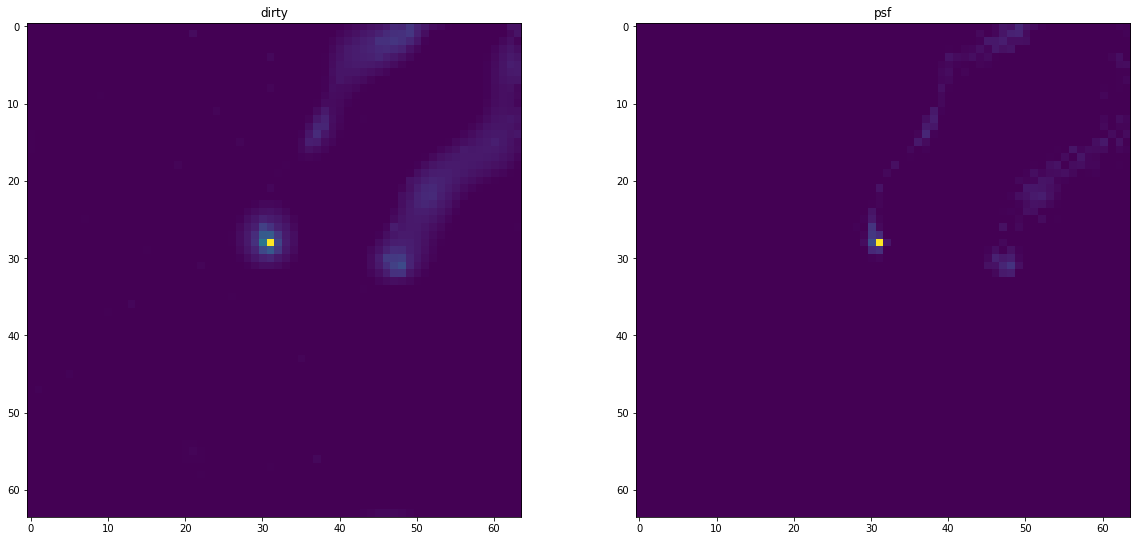

In [221]:
plot_comparison(x_active, 'dirty', x_2, "psf")

In [187]:
x_w0_comparison[x_w0_comparison > 0 ] = 1

In [174]:
np.max(x_w0)

1.071991840423829

In [67]:
def transform(res, x, p, conv):
    for xi in range(0, x.shape[0]):
        print(xi)
        for yi in range(0, x.shape[1]):
            x_old = x[xi, yi]
            pix = np.asarray([xi-32, yi-32])

            f_col = conv * np.exp((-1)*np.dot(p, pix))
            f_r = np.real(f_col)
            f_i = np.imag(f_col)
            res_r = np.real(res)
            res_i = np.imag(res)
            x[xi,yi] = soft_thresh(np.real(np.sum(f_col*res)), lambda_cs)
                

In [68]:
pure = np.zeros(dim)
transform(y, pure, p_prepped, (1 - conv_vis0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


KeyboardInterrupt: 

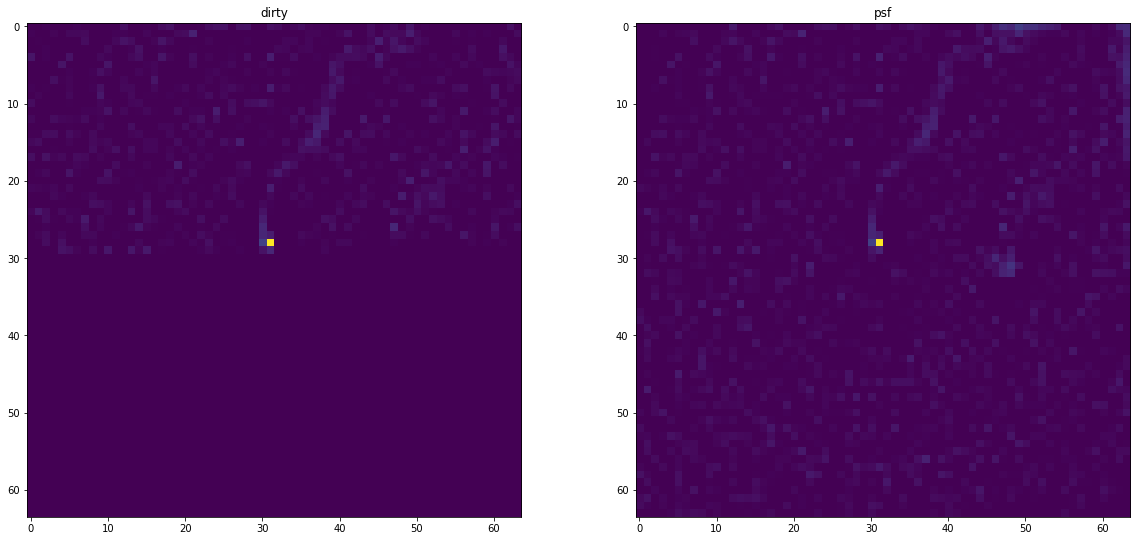

In [69]:
plot_comparison(pure, 'dirty', x_w0, "psf")